In [1]:
# Importing all neccessary Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
# Load Datasets
movies = pd.read_csv(r"D:\DV\movies.csv",encoding='ISO-8859-1')
ratings = pd.read_csv(r"D:\DV\ratings.csv",encoding='ISO-8859-1')

In [3]:
# First Look at the Data
print("🎬 Movies Dataset:")
print(movies.head(), "\n")

🎬 Movies Dataset:
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy   



In [4]:
print("⭐ Ratings Dataset:")
print(ratings.head(), "\n")

⭐ Ratings Dataset:
   userId  movieId  rating   timestamp
0       1      169     2.5  1204927694
1       1     2471     3.0  1204927438
2       1    48516     5.0  1204927435
3       2     2571     3.5  1436165433
4       2   109487     4.0  1436165496 



In [5]:
# Basic Info
print("Movies shape:", movies.shape)
print("Ratings shape:", ratings.shape)

Movies shape: (34208, 3)
Ratings shape: (1048575, 4)


In [6]:
print("Missing values in Movies:\n", movies.isnull().sum())
print("Missing values in Ratings:\n", ratings.isnull().sum())

Missing values in Movies:
 movieId    0
title      0
genres     0
dtype: int64
Missing values in Ratings:
 userId       0
movieId      0
rating       0
timestamp    0
dtype: int64


In [7]:
# Merge datasets on movieId
data = pd.merge(ratings, movies, on='movieId')
print("\n Merged Dataset Sample:")
print(data.head())


 Merged Dataset Sample:
   userId  movieId  rating   timestamp  \
0       1      169     2.5  1204927694   
1       1     2471     3.0  1204927438   
2       1    48516     5.0  1204927435   
3       2     2571     3.5  1436165433   
4       2   109487     4.0  1436165496   

                                     title                    genres  
0  Free Willy 2: The Adventure Home (1995)  Adventure|Children|Drama  
1               Crocodile Dundee II (1988)   Action|Adventure|Comedy  
2                     Departed, The (2006)      Crime|Drama|Thriller  
3                       Matrix, The (1999)    Action|Sci-Fi|Thriller  
4                      Interstellar (2014)               Sci-Fi|IMAX  


In [8]:
# Unique Users and Movies
print("\n--- Unique Users and Movies ---")
print("\n👥 Number of Unique Users:", data['userId'].nunique())
print("🎞️Number of Unique Movies:", data['movieId'].nunique())


--- Unique Users and Movies ---

👥 Number of Unique Users: 11331
🎞️Number of Unique Movies: 17390


In [9]:
# Average Rating per Movie
print("\n--- Average Rating per Movie ---")
avg_rating = data.groupby('title')['rating'].mean().sort_values(ascending=False)
print("\n📊 Top 5 Movies by Average Rating:")
print(avg_rating.head())


--- Average Rating per Movie ---

📊 Top 5 Movies by Average Rating:
title
Under the Domim Tree (Etz Hadomim Tafus) (1994)                         5.0
Undefeated, The (1969)                                                  5.0
Tyler Perry's Temptation: Confessions of a Marriage Counselor (2013)    5.0
Twinsters (2015)                                                        5.0
Live Forever (2003)                                                     5.0
Name: rating, dtype: float64


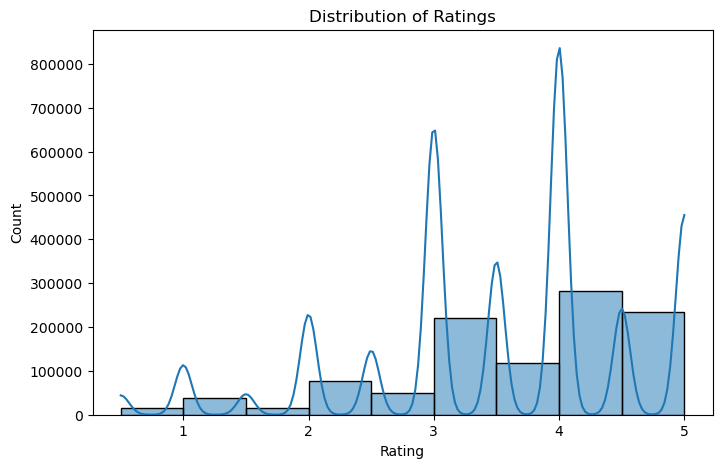

In [10]:
# Distribution of Ratings
plt.figure(figsize=(8, 5))
sns.histplot(data['rating'], bins=9, kde=True)
plt.title("Distribution of Ratings")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()

In [11]:
# Genre Analysis
# Split genres by '|'
genre_data = movies.copy()
genre_data['genres'] = genre_data['genres'].str.split('|')
genres_exploded = genre_data.explode('genres')

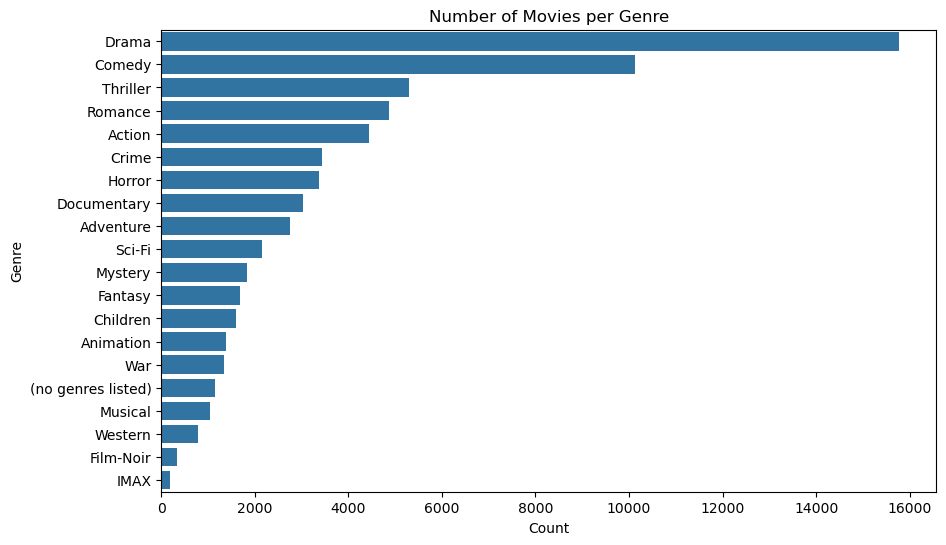

In [12]:
# Genre Frequency
plt.figure(figsize=(10, 6))
sns.countplot(data=genres_exploded, y='genres', order=genres_exploded['genres'].value_counts().index)
plt.title("Number of Movies per Genre")
plt.xlabel("Count")
plt.ylabel("Genre")
plt.show()

In [13]:
def popularity_based_recommender(movies, ratings, genre_input, top_n):
    movies_exploded = movies.copy()
    movies_exploded['genres'] = movies_exploded['genres'].fillna('').astype(str).str.split('|')
    movies_exploded = movies_exploded.explode('genres')
    genre_input = genre_input.lower()
    movies_exploded['genres'] = movies_exploded['genres'].str.lower()

    genre_movies = movies_exploded[movies_exploded['genres'] == genre_input]
    
    if genre_movies.empty:
        return pd.DataFrame(columns=['title', 'avg_rating', 'num_reviews'])
    
    merged = pd.merge(ratings, genre_movies, on='movieId')

    grouped = merged.groupby('title').agg(
        avg_rating=('rating', 'mean'),
        num_reviews=('rating', 'count')
    ).reset_index()

    result = grouped.sort_values(by=['avg_rating', 'num_reviews'], ascending=False).head(top_n)

    return result.reset_index(drop=True)

In [14]:
# 📥 INPUT
genre = input("Enter Genre (e.g., Comedy): ")
top_n = int(input("Enter Number of Recommendations: "))

# 📤 OUTPUT
recommended = popularity_based_recommender(movies, ratings, genre, top_n)

print("\nPopularity-Based Recommendations:")
for i in range(len(recommended)):
    print(f"{i+1}. {recommended['title'][i]}")

Enter Genre (e.g., Comedy):  comedy
Enter Number of Recommendations:  10



Popularity-Based Recommendations:
1. It's Such a Beautiful Day (2012)
2. Airbag (1997)
3. Book of Life, The (1998)
4. High Hopes (1988)
5. Rumble in the Air-Conditioned Auditorium: O'Reilly vs. Stewart 2012, The (2012)
6. A Cinderella Story: Once Upon a Song (2011)
7. Adventures of a Teenage Dragonslayer (I Was a 7th Grade Dragon Slayer) (2010)
8. Afonya (1975)
9. Baggage Claim (2013)
10. Bootleggers (1961)


In [15]:
# Create a pivot table: users as rows, movies as columns, ratings as values
pivot_table = data.pivot_table(index='userId', columns='title', values='rating')

pivot_table.fillna(0, inplace=True)

# Display part of the pivot table
print("\n🎯 Pivot Table (User-Movie Ratings) — Nulls Replaced with 0:")
print(pivot_table.head())


🎯 Pivot Table (User-Movie Ratings) — Nulls Replaced with 0:
title   "Great Performances" Cats (1998)  $5 a Day (2008)  \
userId                                                      
1                                    0.0              0.0   
2                                    0.0              0.0   
3                                    0.0              0.0   
4                                    0.0              0.0   
5                                    0.0              0.0   

title   $ellebrity (Sellebrity) (2012)  '71 (2014)  \
userId                                               
1                                  0.0         0.0   
2                                  0.0         0.0   
3                                  0.0         0.0   
4                                  0.0         0.0   
5                                  0.0         0.0   

title   'Hellboy': The Seeds of Creation (2004)  \
userId                                            
1                             

In [16]:
# Step 1: Create user-movie matrix
user_movie_matrix = ratings.pivot_table(index='userId', columns='movieId', values='rating')
item_movie_matrix = user_movie_matrix.T  # Transpose: now movies are rows

# Step 2: Fill NaN with 0 for similarity computation
item_filled = item_movie_matrix.fillna(0)

# Step 3: Compute cosine similarity between movies
item_similarity = cosine_similarity(item_filled)
item_similarity_df = pd.DataFrame(item_similarity, index=item_filled.index, columns=item_filled.index)

# Step 4: Item-based collaborative recommender
def item_based_recommender(movie_id, top_n=5):
    if movie_id not in item_similarity_df.index:
        return f"❌ Movie ID {movie_id} not found."

    similar_scores = item_similarity_df[movie_id].sort_values(ascending=False).drop(movie_id)
    top_similar_ids = similar_scores.head(top_n).index

    return movies[movies['movieId'].isin(top_similar_ids)][['title']].reset_index(drop=True)

In [20]:
# 📥 INPUT
movie_title = input("Enter a Movie Title (e.g., Toy Story): ")
top_n = int(input("Enter Number of Similar Movies to Recommend: "))

# Find movie ID from title (case-insensitive match and strip any extra spaces)
movie_row = movies[movies['title'].str.strip().str.lower() == movie_title.strip().lower()]

# 📤 OUTPUT
print("\n🎯 Item-Based Collaborative Recommendations:")
if movie_row.empty:
    print("❌ Movie title not found.")
else:
    movie_id = movie_row.iloc[0]['movieId']
    
    # Make sure the recommender function exists and returns valid results
    try:
        recommendations = item_based_recommender(movie_id, top_n=top_n)
        print(recommendations)
    except Exception as e:
        print("⚠️ An error occurred while generating recommendations:", e)

Enter a Movie Title (e.g., Toy Story):  Waiting to Exhale (1995)
Enter Number of Similar Movies to Recommend:  100



🎯 Item-Based Collaborative Recommendations:
                                                title
0                      American President, The (1995)
1                                  Money Train (1995)
2                                   Get Shorty (1995)
3                                       Powder (1995)
4                                 Now and Then (1995)
..                                                ...
95                        Operation Dumbo Drop (1995)
96             Promise, The (Versprechen, Das) (1995)
97                Truth About Cats & Dogs, The (1996)
98                       First Wives Club, The (1996)
99  JLG/JLG (JLG/JLG - autoportrait de dÃ©cembre) ...

[100 rows x 1 columns]
